`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   




# Лабораторная работа №3: Линейные модели. Кросс-валидация. 

В практических примерах ниже показано:   

* как пользоваться инструментами предварительного анализа для поиска линейных взаимосвязей 
* как строить и интерпретировать линейные модели с логарифмами  
* как оценивать точность моделей с перекрёстной проверкой (проверка по блокам)

*Модели*: множественная линейная регрессия 
*Данные*: `Auto_for_lab` (источник: <https://raw.githubusercontent.com/ania607/ML/main/data/Auto_for_lab.csv>)

# Указания к выполнению


## Загружаем пакеты

In [48]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
#  тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
#  для таймера
import time

# загрузка пакетов: модели -------------------------------------------------
#  линейные модели
import sklearn.linear_model as skl_lm
#  расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut 
from sklearn.model_selection import KFold, cross_val_score
#  полиномиальные модели
from sklearn.preprocessing import PolynomialFeatures

In [49]:
# константы
#  ядро для генератора случайных чисел
my_seed = 6
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

## Загружаем данные

Набор данных `Auto_for_lab` в формате .csv доступен для загрузки по адресу: <https://raw.githubusercontent.com/ania607/ML/main/data/Auto_for_lab.csv>. 
Загружаем данные во фрейм и кодируем категориальные переменные.  

In [50]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/Auto_for_lab.csv'
DF_raw = pd.read_csv(fileURL)

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (392, 10)


In [51]:
# первые 5 строк фрейма
DF_raw.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,cyl_over_4
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,1
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,1
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,1
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,1
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,1



* **mpg**- мили на галлон;
* **cylinders**– количество цилиндров;
* **displacement**– объем двигателя;
* **horsepower**– количество лошадиных сил;
* **weight**– вес автомобиля;
* **acceleration**– разгон;
* **year**– от 70 до 82;
* **origin**– континент производства.
* **name**– название автомобиля.
* **cyl_over_4**– количество цилиндров больше 4(0-нет;1-да).

In [52]:
# типы столбцов фрейма
DF_raw.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower        int64
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
cyl_over_4        int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [53]:
# считаем пропуски в каждом столбце
DF_raw.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
cyl_over_4      0
dtype: int64

Пропусков не обнаружено.  

In [55]:


# находим уникальные mpg
DF_raw['origin'].unique()

array([1, 3, 2], dtype=int64)

In [56]:
#  добавляем фиктивные на : число фиктивных = число уникальных - 1
df_dummy = pd.get_dummies(DF_raw[['origin']], drop_first=True)
df_dummy.head()

,origin
0,1
1,1
2,1
3,1
4,1


In [57]:
# объединяем с исходным фреймом
DF_all = pd.concat([DF_raw.reset_index(drop=True), df_dummy], axis=1)

# сколько теперь столбцов
DF_all.shape

(392, 11)

In [58]:
# смотрим первые 8 столбцов
DF_all.iloc[:, :8].head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [59]:
# смотрим последние 5 столбцов
DF_all.iloc[:, 8:].head()

,name,cyl_over_4,origin
0,chevrolet chevelle malibu,1,1
1,buick skylark 320,1,1
2,plymouth satellite,1,1
3,amc rebel sst,1,1
4,ford torino,1,1


In [60]:
# оставляем в наборе данных только то, что нужно 
#  (плюс метки регионов для графиков)
DF_all = DF_all[['mpg', 'displacement', 'acceleration', 'cyl_over_4']]

# перекодируем регион в числовой фактор, 
#  чтобы использовать на графиках
class_le = LabelEncoder()
DF_all['mpg'] = class_le.fit_transform(DF_all.mpg.values)

DF_all.columns

Index(['mpg', 'displacement', 'acceleration', 'cyl_over_4'], dtype='object')

In [61]:
DF_all.dtypes

mpg               int64
displacement    float64
acceleration    float64
cyl_over_4        int64
dtype: object

In [62]:
# удаляем фрейм-исходник
del DF_raw


Прежде чем переходить к анализу данных, разделим фрейм на две части: одна (80%) станет основой для обучения моделей, на вторую (20%) мы сделаем прогноз по лучшей модели.  

In [63]:
# данные для построения моделей
DF = DF_all.sample(frac=0.8, random_state=my_seed)

# данные для прогнозов
DF_predict = DF_all.drop(DF.index)

## Предварительный анализ данных   

### Считаем описательные статистики   

Рассчитаем описательные статистики для непрерывных переменных. Из таблицы ниже можно видеть, что переменная `charges`, которая является зависимой переменной модели, сильно отличается по масштабу от всех остальных.    Также заметим, что из всех объясняющих только переменная `children` принимает нулевые значения. Остальные показатели положительны.  

In [64]:
# описательные статистики для непрерывных переменных
DF[['mpg', 'displacement', 'acceleration', 'cyl_over_4']].describe()


,mpg,displacement,acceleration,cyl_over_4
count,314.000000,314.000000,314.000000,314.000000
mean,44.770701,196.547771,15.424841,0.496815
std,34.406028,104.970128,2.652159,0.500788
min,0.000000,68.000000,8.000000,0.000000
25%,13.000000,105.000000,13.800000,0.000000
50%,38.000000,151.000000,15.400000,0.000000
75%,70.750000,302.000000,17.000000,1.000000
max,126.000000,455.000000,24.800000,1.000000


### Строим графики  

Посмотрим на графики взаимного разброса непрерывных переменных. 

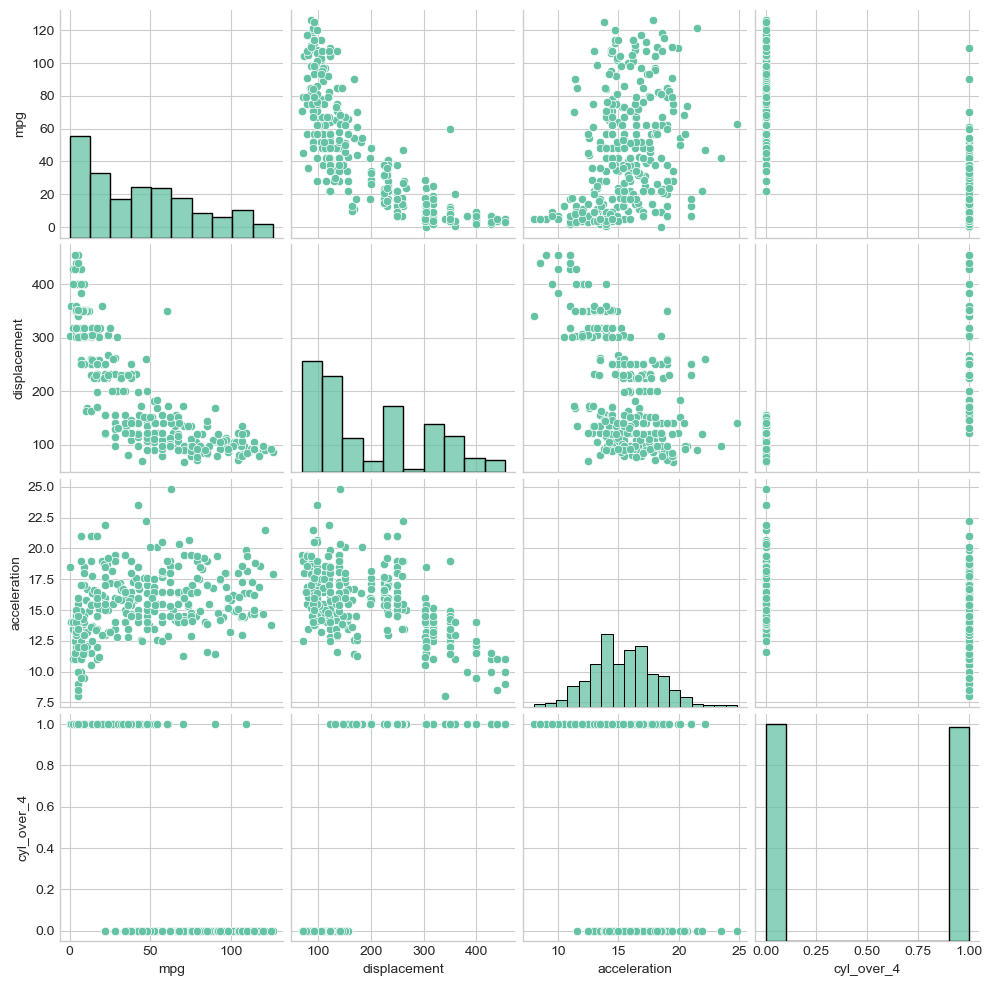

In [65]:
# матричный график разброса с линиями регрессии
sns.pairplot(DF[['mpg', 'displacement', 'acceleration', 'cyl_over_4']])
plt.show()

Судя по этим графикам:  
* распределение зависимой `mpg` не является нормальным;  
* из всех объясняющих нормально распределена только `acceleration`;  
* имеется четыре уровня разгона, что заметно на графиках разброса `displacement`, `acceleration`;  
* объясняющая `cyl_over_4` дискретна, что очевидно из её смысла: ;  
* разброс значений `displacement` у автомобилей с количеством цилиндров 4 и меньше (максимум из таблицы выше) намного меньше, чем у остальных автомобилей.  

Наблюдаемые закономерности могут объясняться влиянием одной или нескольких из фиктивных объясняющих переменных. Построим график, раскрасив точки цветом в зависимости от mpg.  

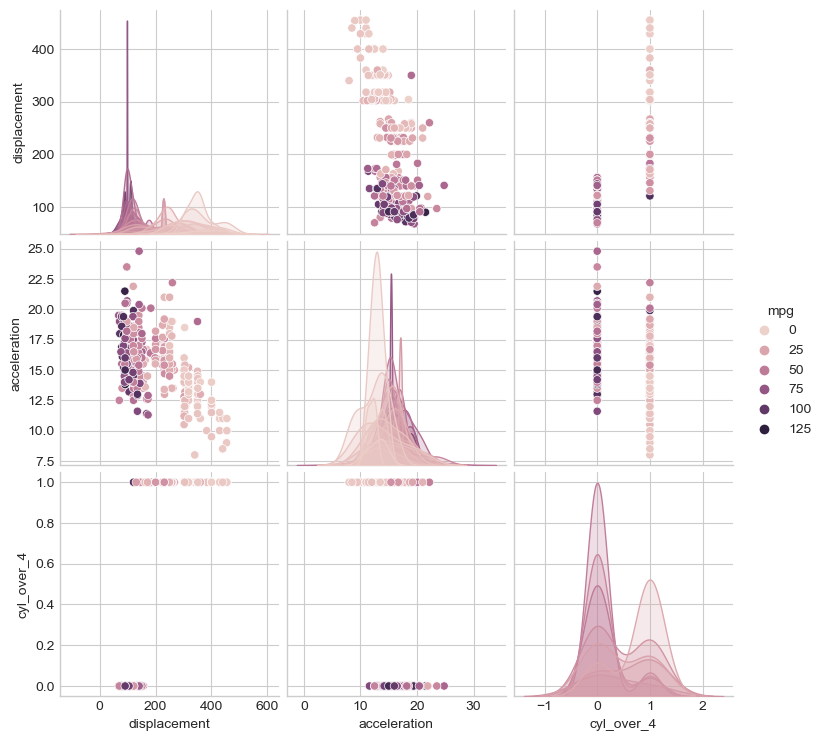

In [67]:
# матричный график разброса с цветом по mpg
sns.pairplot(DF[['mpg', 'displacement', 'acceleration', 'cyl_over_4']],
            hue='mpg')

plt.show()

Теперь покажем цветом на графиках отношение автомобилей от количества цилиндров больше 4.

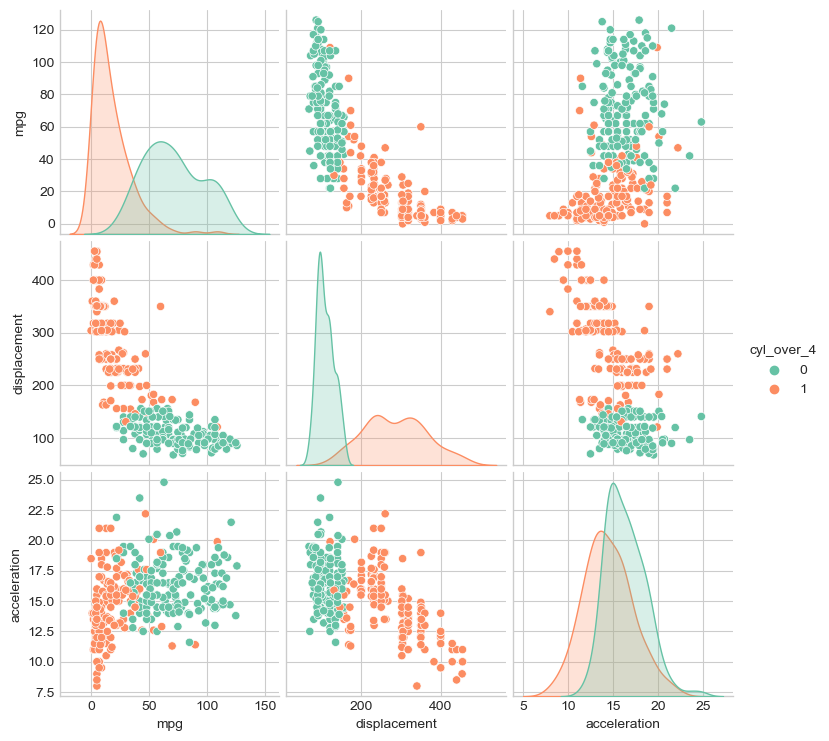

In [68]:
# матричный график разброса с цветом по cyl_over_4
sns.pairplot(DF[['mpg', 'displacement', 'acceleration', 'cyl_over_4']],
            hue='cyl_over_4')

plt.show()

Покажем с помощью цвета на графиках объема двигателя.

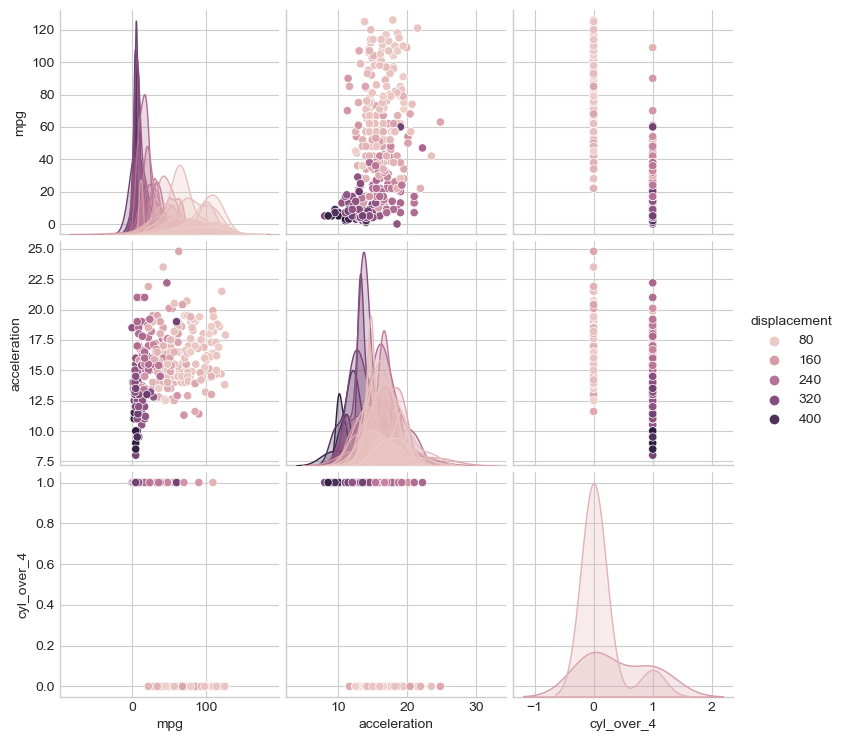

In [70]:
# матричный график разброса с цветом по region
sns.pairplot(DF[['mpg', 'displacement', 'acceleration', 'cyl_over_4']], hue='displacement')
plt.show()

Нарисуем график отдельно по `region_southeast`.  

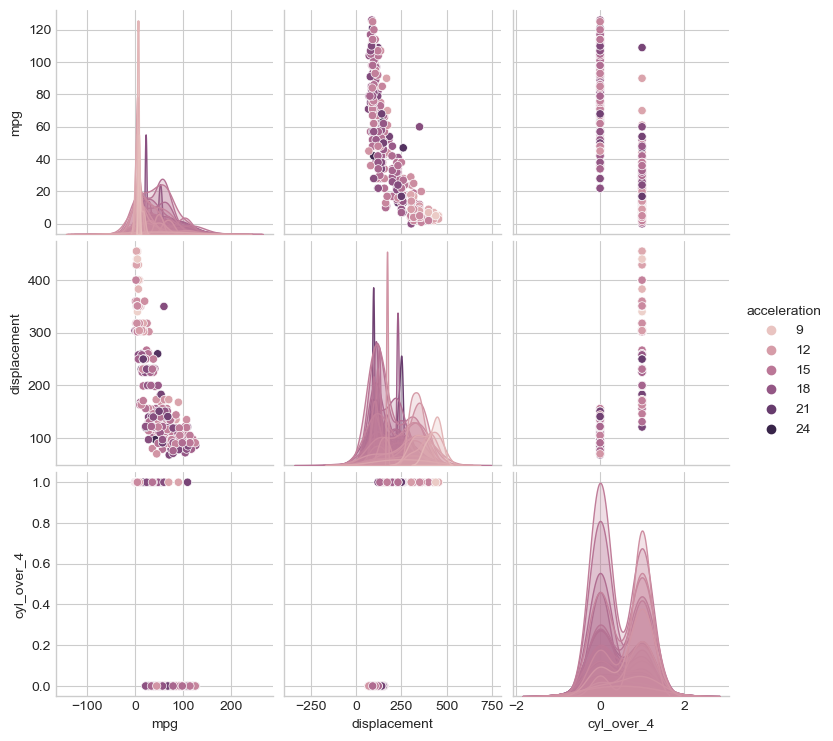

In [71]:
# матричный график разброса с цветом по разгону
sns.pairplot(DF[['mpg', 'displacement', 'acceleration', 'cyl_over_4']], hue='acceleration')
plt.show()

Посмотрим на корреляционные матрицы непрерывных переменных фрейма. 

In [72]:
# корреляционная матрица по всем наблюдениям
corr_mat = DF[['mpg', 'displacement', 'acceleration', 'cyl_over_4']].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
#corr_mat

C:\Users\Credu\AppData\Local\Temp\ipykernel_21196\3624074173.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)


,mpg,displacement,acceleration,cyl_over_4
mpg,1.00,-0.81,0.35,-0.77
displacement,-0.81,1.00,-0.54,0.84
acceleration,0.35,-0.54,1.00,-0.37
cyl_over_4,-0.77,0.84,-0.37,1.00


Посчитаем корреляционные матрицы для количество цилиндров больше 4 и меньше.  

In [73]:
# корреляционная матрица по классу количество цилиндров больше 4
corr_mat = DF.loc[DF['cyl_over_4'] == 1][['mpg', 'displacement', 'acceleration']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat

,mpg,displacement,acceleration
mpg,1.000000,-0.664278,0.329399
displacement,-0.664278,1.000000,-0.600760
acceleration,0.329399,-0.600760,1.000000


In [74]:
# корреляционная матрица по классу количество цилиндров  4 и меньше
corr_mat = DF.loc[DF['cyl_over_4'] == 0][['mpg', 'displacement', 'acceleration']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat

,mpg,displacement,acceleration
mpg,1.000000,-0.468339,-0.046060
displacement,-0.468339,1.000000,-0.068842
acceleration,-0.046060,-0.068842,1.000000




### Логарифмируем зависимую переменную  

Важным допущением линейной регрессии является нормальность зависимой переменной. Чтобы добиться нормального распределения, используют логарифмирование либо преобразование Бокса-Кокса. В этой лабораторной остановимся на логарифмировании.   

In [78]:
# логарифмируем зависимую переменную
DF['log_mpg'] = np.log(DF['mpg'])
DF['log_mpg'][DF['log_mpg'] == -inf] = 0.000000001

# описательные статистики для непрерывных показателей
DF[['mpg','log_mpg', 'displacement', 'acceleration', 'cyl_over_4']].describe()

D:\anaconda3\envs\env02\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Credu\AppData\Local\Temp\ipykernel_21196\3964014464.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF['log_mpg'][DF['log_mpg'] == -inf] = 0.000000001


,mpg,log_mpg,displacement,acceleration,cyl_over_4
count,314.000000,314.000000,314.000000,314.000000,314.000000
mean,44.770701,3.349147,196.547771,15.424841,0.496815
std,34.406028,1.108419,104.970128,2.652159,0.500788
min,0.000000,0.000000,68.000000,8.000000,0.000000
25%,13.000000,2.564949,105.000000,13.800000,0.000000
50%,38.000000,3.637586,151.000000,15.400000,0.000000
75%,70.750000,4.259134,302.000000,17.000000,1.000000
max,126.000000,4.836282,455.000000,24.800000,1.000000


Проведём формальные тесты на нормальность.  

In [79]:
# тестируем на нормальность
for col in ['mpg', 'log_mpg']:
    stat, p = shapiro(DF[col])
    print(col, 'Statistics=%.2f, p=%.4f' % (stat, p))
    # интерпретация
    alpha = 0.05
    if p > alpha:
        print('Распределение нормально (H0 не отклоняется)\n')
    else:
        print('Распределение не нормально (H0 отклоняется)\n')

mpg Statistics=0.92, p=0.0000
Распределение не нормально (H0 отклоняется)

log_mpg Statistics=0.92, p=0.0000
Распределение не нормально (H0 отклоняется)



Логарифмирование меняет взаимосвязи между переменными.   

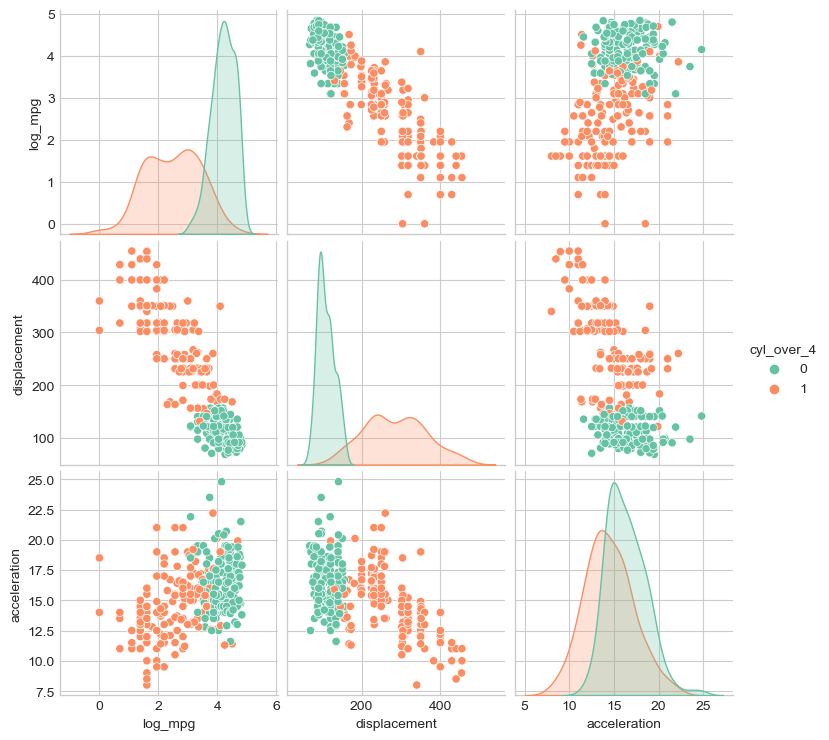

In [80]:
# матричный график разброса с цветом по cyl_over_4
sns.pairplot(DF[['log_mpg', 'displacement', 'acceleration', 'cyl_over_4']], hue='cyl_over_4')
plt.show()

In [83]:
# корреляционная матрица по классу не курильщиков
corr_mat = DF.loc[DF['cyl_over_4'] == 0][['log_mpg', 'displacement', 'acceleration']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat

,log_mpg,displacement,acceleration
log_mpg,1.000000,-0.453996,-0.070832
displacement,-0.453996,1.000000,-0.068842
acceleration,-0.070832,-0.068842,1.000000


In [85]:
# корреляционная матрица по классу цилиндров больше 4
corr_mat = DF.loc[DF['cyl_over_4'] == 1][['log_mpg', 'displacement', 'acceleration']].corr()
#corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_mat


,log_mpg,displacement,acceleration
log_mpg,1.000000,-0.750052,0.401613
displacement,-0.750052,1.000000,-0.600760
acceleration,0.401613,-0.600760,1.000000


## Строим модели регрессии

### Спецификация моделей  
По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:  

1. `fit_lm_1`: $\hat{mpg} = \hat{\beta_0} + \hat{\beta_1} \cdot cyl\_over\_4 + \hat{\beta_2} \cdot displacement + \hat{\beta_3} \cdot acceleration$
1. `fit_lm_2`: $\hat{mpg} = \hat{\beta_0} + \hat{\beta_1} \cdot cyl\_over\_4 + \hat{\beta_2} \cdot displacement \cdot cyl\_over\_4 + \hat{\beta_3} \cdot acceleration$
1. `fit_lm_3`: $\hat{mpg} = \hat{\beta_0} + \hat{\beta_1} \cdot cyl\_over\_4 + \hat{\beta_2} \cdot acceleration \cdot cyl\_over\_4 + \hat{\beta_3} \cdot displacement$
1. `fit_lm_4`: $\hat{mpg} = \hat{\beta_0} + \hat{\beta_1} \cdot cyl\_over\_4 + \hat{\beta_2} \cdot acceleration \cdot cyl\_over\_4 + \hat{\beta_3} \cdot displacement \cdot cyl\_over\_4$

1. `fit_lm_1_log`: то же, что `fit_lm_1`, но для зависимой $\hat{log\_mpg}$  
1. `fit_lm_2_log`: то же, что `fit_lm_2`, но для зависимой $\hat{log\_mpg}$
1. `fit_lm_3_log`: то же, что `fit_lm_3`, но для зависимой $\hat{log\_mpg}$
1. `fit_lm_4_log`: то же, что `fit_lm_4`, но для зависимой $\hat{log\_mpg}$

Кроме того, добавим в сравнение модели зависимости `charges` и `log_sharges` от всех объясняющих переменных: `fit_lm_0` и `fit_lm_0_log` соответственно.  


### Обучение и интерпретация  

Создаём матрицы значений объясняющих переменных ( $X$ ) и вектора значений зависимой ( $y$ ) для всех моделей.  

In [86]:
# данные для моделей 1, 5
df1 = DF[['mpg', 'displacement', 'acceleration', 'cyl_over_4']]

# данные для моделей 2, 6
df2 = DF[['mpg', 'displacement', 'acceleration', 'cyl_over_4']]
df2.loc[:, 'displacement_cyl_over_4'] = df2.loc[:, 'displacement'] * df2.loc[:, 'cyl_over_4']
df2 = df2.drop(['displacement'], axis=1)

# данные для моделей 3, 7
df3 = DF[['mpg', 'displacement', 'acceleration', 'cyl_over_4']]
df3.loc[:, 'acceleration_cyl_over_4'] = df3.loc[:, 'acceleration'] * df3.loc[:, 'cyl_over_4']
df3 = df3.drop(['acceleration'], axis=1)

# данные для моделей 4, 8
df4 = DF[['mpg', 'displacement', 'acceleration', 'cyl_over_4']]
df4.loc[:, 'displacement_cyl_over_4'] = df4.loc[:, 'displacement'] * df4.loc[:, 'cyl_over_4']
df4.loc[:, 'acceleration_cyl_over_4'] = df4.loc[:, 'acceleration'] * df4.loc[:, 'cyl_over_4']
df4 = df4.drop(['acceleration', 'displacement'], axis=1)

# данные для моделей 9, 10
df0 = DF.drop(['log_mpg'], axis=1)

In [87]:
# проверка результатов
df4.head()


,mpg,cyl_over_4,displacement_cyl_over_4,acceleration_cyl_over_4
364,97,0,0.0,0.0
136,5,1,318.0,13.5
13,5,1,455.0,10.0
209,11,1,168.0,16.7
299,99,0,0.0,0.0


Построим модели от всех объясняющих переменных на всех наблюдениях `DF`, чтобы проинтерпретировать параметры. В модели для зависимой переменной `mpg` интерпретация стандартная:  

1. Константа – базовый уровень зависимой переменной, когда все объясняющие равны 0.  
2. Коэффициент при объясняющей переменной $X$ показывает, на сколько своих единиц измерения изменится $Y$, если $X$ увеличится на одну свою единицу измерения.  

In [88]:
lm = skl_lm.LinearRegression()

# модель со всеми объясняющими, y
X = df0.drop(['mpg'], axis=1)
y = df0.mpg.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель fit_lm_0:\n', 
      'константа ', np.around(fit_lm_0.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0.coef_, 3))


модель fit_lm_0:
 константа  [109.794] 
 объясняющие  ['displacement', 'acceleration', 'cyl_over_4'] 
 коэффициенты  [[ -0.196  -1.053 -20.511]]


In [89]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0.predict(X)
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
np.sqrt(MSE)

array([19.26466182])

С интерпретацией модели на логарифме $Y$ дела обстоят сложнее:  
1. Константу сначала надо экспоненциировать, далее интерпретировать как для обычной модели регрессии.  
1. Коэффициент при $X$ нужно экспоненциировать, затем вычесть из получившегося числа 1, затем умножить на 100. Результат показывает, на сколько процентов изменится (увеличится, если коэффициент положительный, и уменьшится, если отрицательный) зависимая переменная, если $X$ увеличится на одну свою единицу измерения.  

In [97]:
# модель со всеми объясняющими, y_log
from numpy import inf
X = df0.drop(['mpg'], axis=1)
y = np.log(df0.mpg).values.reshape(-1, 1)
y[y == -inf] = 0.0000001

fit_lm_0_log = lm.fit(X, y)
print('модель fit_lm_0_log:\n', 
      'константа ', np.around(fit_lm_0_log.intercept_, 3),
      '\n объясняющие ', list(X.columns.values),
      '\n коэффициенты ', np.around(fit_lm_0_log.coef_, 3))

модель fit_lm_0_log:
 константа  [5.565] 
 объясняющие  ['displacement', 'acceleration', 'cyl_over_4'] 
 коэффициенты  [[-0.009 -0.022 -0.094]]


D:\anaconda3\envs\env02\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [98]:
# пересчёт коэффициентов для их интерпретации
np.around((np.exp(fit_lm_0_log.coef_) - 1) * 100, 1)

array([[-0.9, -2.1, -9. ]])

In [99]:
# оценим MSE на обучающей
#  прогнозы
y_pred = fit_lm_0_log.predict(X)
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
np.sqrt(MSE_log)

array([18.44852409])

In [100]:
print('MSE_train модели для mpg меньше MSE_train',
     'модели для log(mpg) в ', np.around(MSE_log / MSE, 2), 'раз')

MSE_train модели для mpg меньше MSE_train модели для log(mpg) в  [0.92] раз


### Оценка точности

Расчёты методом LOOCV заняли 18.72 секунд


(1204, 9)

Расчёты методом LOOCV заняли 18.57 секунд


[-36576879.422501296,
 -36751828.6626254,
 -46613497.180963166,
 -23782780.048677843,
 -34990547.452314906]

[36576879.42, 36751828.66, 46613497.18, 23782780.05, 34990547.45]

[0.197, 0.217, 0.461, 0.204, 0.455]

Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_3 :
MSE_loocv = 23782780.0


Наименьшая ошибка на тестовой с LOOCV у модели fit_lm_0_log :
MSE_loocv = 0.197


#### Перекрёстная проверка по блокам    

Теоретически этот метод менее затратен, чем LOOCV. Проверим на наших моделях.   

In [101]:
# Перекрёстная проверка по 10 блокам
folds = 5

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['mpg'], axis=1)
    y = df.mpg
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.09 секунд


In [39]:
# Перекрёстная проверка по 10 блокам
folds = 5

# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)

# модели для y
scores_log = list()
# таймер
tic = time.perf_counter()
i = 0
for df in [df0, df1, df2, df3, df4] :
    X = df.drop(['mpg'], axis=1)
    y = np.log(df.mpg)
    kf_10 = KFold(n_splits=folds, random_state=r_state[i],
                 shuffle=True)
    score = cross_val_score(lm, X, y, cv=kf_10,
                            scoring='neg_mean_squared_error').mean()
    scores_log.append(score)
    i+=1

# таймер
toc = time.perf_counter()
print(f"Расчёты методом CV по 5 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 5 блокам заняли 0.13 секунд


D:\anaconda3\envs\env02\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\anaconda3\envs\env02\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda3\envs\env02\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "D:\anaconda3\envs\env02\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "D:\anaconda3\envs\env02\lib\site-packages\sklearn\metrics\_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "D:\anaconda3\envs\env02\lib\site-packages\sklearn\metrics\_regression.py", line

In [102]:
scores

[-387.4568686216618,
 -385.9982116434147,
 -418.9652193677772,
 -378.792164699759,
 -416.0675806529538]

In [103]:
# самая точная на charges
fits = ['fit_lm_0', 'fit_lm_1', 'fit_lm_2', 'fit_lm_3', 'fit_lm_4']
print('Наименьшая ошибка на тестовой с k-fold5 у модели',
      fits[scores.index(max(scores))], 
      ':\nMSE_kf10 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold5 у модели fit_lm_3 :
MSE_kf10 = 379.0


In [104]:
# самая точная на log(charges)
fits = ['fit_lm_0_log', 'fit_lm_1_log', 'fit_lm_2_log', 
        'fit_lm_3_log', 'fit_lm_4_log']
print('Наименьшая ошибка на тестовой с k-fold5 у модели',
      fits[scores_log.index(max(scores_log))], 
      ':\nMSE_kf10 =', np.around(-max(scores_log), 3))

Наименьшая ошибка на тестовой с k-fold5 у модели fit_lm_0_log :
MSE_kf10 = nan


Самой точной среди моделей для `mpg` оказалась `fit_lm_3`, а среди моделей для `mpg_log` – `fit_lm_0_log`. Оценим точность прогноза по этим моделям на отложенные наблюдения.   

In [105]:
# прогноз по fit_lm_3
#  модель на всех обучающих наблюдениях
X = df3.drop(['mpg'], axis=1)
y = df3.mpg.values.reshape(-1, 1)
fit_lm_3 = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = DF_predict[['mpg']].values.reshape(-1, 1)
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict[['cyl_over_4', 'displacement', 'acceleration']]
X.loc[:, 'acceleration_cyl_over_4'] = X.loc[:, 'acceleration'] * X.loc[:, 'cyl_over_4']
X = X.drop(['acceleration'], axis=1)
#  прогнозы
y_pred = fit_lm_3.predict(X)

# ошибка
MSE = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_3 на отложенных наблюдениях = %.2f' % MSE)

MSE модели fit_lm_3 на отложенных наблюдениях = 558208.23


D:\anaconda3\envs\env02\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [106]:
# прогноз по fit_lm_log_0
# модель
X = df0.drop(['mpg'], axis=1)
y = np.log(df0.mpg).values.reshape(-1, 1)
y[y == -inf] = 0 
fit_lm_0_log = lm.fit(X, y)

#  значения y на отложенных наблюдениях
y = np.log(DF_predict[['mpg']].values.reshape(-1, 1))
#  матрица объясняющих на отложенных наблюдениях
X = DF_predict.drop(['mpg'], axis=1)

#  прогнозы
y_pred = fit_lm_0_log.predict(X)

# ошибка
MSE_log = sum((np.exp(y) - np.exp(y_pred).reshape(-1, 1))**2) / len(y)
print('MSE модели fit_lm_0_log на отложенных наблюдениях = %.2f' % MSE_log)

MSE модели fit_lm_0_log на отложенных наблюдениях = 704.94


D:\anaconda3\envs\env02\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [107]:
np.sqrt(MSE_log) / np.mean(DF_predict[['mpg']]) * 100

D:\anaconda3\envs\env02\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


mpg    53.832945
dtype: float64

In [108]:
np.sqrt(MSE) / np.mean(DF_predict[['mpg']]) * 100

D:\anaconda3\envs\env02\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


mpg    1514.853154
dtype: float64

Очевидно, на выборке для прогноза точнее модель `fit_lm_3`:  
$\hat{charges} = \hat{\beta_0} + \hat{\beta_1} \cdot smokerYes + \hat{\beta_2} \cdot bmi \cdot smokerYes + \hat{\beta_3} \cdot age$

In [109]:
X = df3.drop(['mpg'], axis=1)
y = df3.mpg.values.reshape(-1, 1)
fit_lm_3 = lm.fit(X, y)

print('модель fit_lm_3:\n', 
      'константа ', np.around(fit_lm_3.intercept_, 3),
      '\n объясняющие ', list(df3.drop(['mpg'], axis=1).columns.values),
      '\n коэффициенты ', np.around(fit_lm_3.coef_, 3))

модель fit_lm_3:
 константа  [93.282] 
 объясняющие  ['displacement', 'cyl_over_4', 'acceleration_cyl_over_4'] 
 коэффициенты  [[-0.203  3.329 -1.426]]


# Источники 

1. *James G., Witten D., Hastie T. and Tibshirani R.*  An Introduction to Statistical Learning with Applications in R. URL: [http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf](https://drive.google.com/file/d/15PdWDMf9hkfP8mrCzql_cNiX2eckLDRw/view?usp=sharing)     
1. Рашка С. Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.
1. Interpreting Log Transformations in a Linear Model / virginia.edu. URL: <https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/>  
1. Python Timer Functions: Three Ways to Monitor Your Code / realpython.com. URL: <https://realpython.com/python-timer/>  